In [1]:
import re
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

pd.set_option('display.max_colwidth', 200)
%matplotlib inline

In [2]:
import spacy
from spacy import displacy
from spacy.matcher import Matcher
from spacy.tokens import Span


import networkx as nx

# load data

In [3]:
DATA_PATH = 'wiki_sentences_v2.csv'

sentences = pd.read_csv(DATA_PATH)

sentences.head()

,sentence
0,"confused and frustrated, connie decides to leave on her own."
1,"later, a woman’s scream is heard in the distance."
2,christian is then paralyzed by an elder.
3,the temple is set on fire.
4,"outside, the cult wails with him."


In [4]:
sentences.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4318 entries, 0 to 4317
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   sentence  4318 non-null   object
dtypes: object(1)
memory usage: 33.9+ KB


# use spacy for NER,POS tagging and dependency parsing

In [5]:
spacy_english  = spacy.load('en_core_web_sm')

<h2> sentence segmentation </h2>

Dependecy Relations

In [9]:
sample = 'its predecessor was the dutch historical film archive, founded in 1946'

extracted_attributes = spacy_english(sample)

for token in extracted_attributes:
    print(token.text,'|',token.dep_)

its | poss
predecessor | nsubj
was | ROOT
the | det
dutch | amod
historical | amod
film | attr
archive | amod
, | punct
founded | acl
in | prep
1946 | pobj


To build a knowledge graph, we require sets of nodes and edges having the relationship between any two nodes, these are called as triples 
<b>||(node1,reln_edge,node2)<b>||

The entities in the sentences will be the nodes and the edges will be the relationship between these entities, they will be extracted using Grammar of the sentences.

The way to do this is : <br>
<ul>Go through the sentence, keep extracting the subject and the object as they are encountered, keeping in mind that some entities can be of multple words. <ul>

The function below helps to extract multi word entities based on the dependency tag.

In [65]:
def extract_entities(sentence):
    
    entity_1 = ''
    entity_2 = ''
    
    prev_dependency_tok = ''
    prev_text_tok = ''
    prefix = ''
    modifier = ''
    
    for token in spacy_english(sentence):

        if token.dep_ is not 'punct':
            
# check: token is a compound word or not
            if token.dep_ != 'compound':
                
                prefix = token.text
                
# if the previous word was also a 'compound' then add the current word to it   
                if prev_dependency_tok == 'compound':
                    prefix = prev_text_tok + ' ' + token.text
            
#check if the token is a modifier
            if token.dep_.endswith('mod') == True:
                modifier = token.text

# if the previous word was also a 'compound' then add the current word to it   
                if prev_dependency_tok == 'compound':
                    modifier = prev_text_tok + ' ' + token.text
            
            if token.dep_.find('subj') == True:
                
                entity_1 = modifier + ' ' + prefix
                
                prefix = ''
                modifier = ''
                prev_dependency_tok = ''
                prev_text_tok = ''
                
            if token.dep_.find('obj') == True:
                entity_2 = modifier + ' ' + prefix 
                
            prev_dependency_tok = token.dep_
            prev_text_tok = token.text
            
    
    return [entity_1.strip(),entity_2.strip()]

In [66]:
extract_entities('the film had a football stadium')

['film', 'football stadium']

In [67]:
%%time
entity_pairs = [extract_entities(sentence) for sentence in tqdm(sentences['sentence'])]


Wall time: 24.7 s


In [69]:
entity_pairs[10:25]

[['we', 'tests'],
 ['m global', 'international sales rights'],
 ['canadian robbie robertson', 'soundtrack'],
 ['it', 'original music tracks'],
 ['it', 'reviewed franchise'],
 ['she', 'accidentally mystique'],
 ['military forces', 'arrest'],
 ['train', 'vuk'],
 ['', 'selene gallio'],
 ['singer', 'sequel'],
 ['last which', 'penn'],
 ['jessica chastain', 'same character'],
 ['mauro fiore', 'cinematographer'],
 ['filming', 'october'],
 ['soundtrack', 'digitally june']]

Extract Relations <br>
"Sixty Hollywood musicals were released in 1929" <br>
In the above sentence, "releases in" will be the relation between two nodes.

In [74]:
def extract_relations(sentence):
    
    att_sentence = spacy_english(sentence)
    
    matcher = Matcher(spacy_english.vocab)
    
    pattern = [{'DEP':'ROOT'},
              {'DEP':'prep','OP':'?'},
              {'DEP':'agent','OP':'?'},
              {'POS':'ADJ','OP':'?'}]
    
    
    matcher.add('matching_type1',None,pattern)
    
    matches = matcher(att_sentence)
    
    num_matches = len(matches) - 1
    
    span = att_sentence[matches[num_matches][1]:matches[num_matches][2]]
    
    return (span.text)

In [92]:
extract_entities('Sixty Hollywood musicals were released in 1929')

['Hollywood musicals', '1929']

In [93]:
extract_relations('Sixty Hollywood musicals were released in 1929')

'released in'

In [79]:
relations = [extract_relations(sentence) for sentence in tqdm(sentences['sentence'])]

TOP 50 relations

In [80]:
pd.Series(relations).value_counts()[:50]

is               372
was              302
released on       88
are               74
include           72
were              67
released          42
's                39
composed by       35
became            31
have              31
has               30
become            28
released in       27
included          25
called            21
had               21
considered        20
made              20
been              19
produced          19
used              18
scheduled         17
be                16
written by        15
received          15
stars             14
hired             14
wrote             14
produced by       14
went              13
introduced in     13
wanted            12
directed by       12
began in          11
began             11
won               11
set               10
gave              10
features          10
sold              10
said               9
opened             9
reported           9
cast as            9
produced in        9
used in            9
shot in      

In [82]:
source_nodes = [node_pair[0] for node_pair in entity_pairs]
target_nodes = [node_pair[1] for node_pair in entity_pairs]

knowledge_graph_df = pd.DataFrame({'source_node':source_nodes,
                                  'target_node':target_nodes,
                                  'relation':relations})

In [83]:
knowledge_graph_df

,source_node,target_node,relation
0,connie,own,decides
1,later woman,distance,heard in
2,christian,then elder,paralyzed by
3,temple,fire,set on
4,outside cult,him,wails with
...,...,...,...
4313,confidencial,negatively film,responded
4314,le parisien,five star rating,gave
4315,museum collection,"37,000 film titles",includes
4316,predecessor,archive 1946,was


In [85]:
directed_graph = nx.from_pandas_edgelist(knowledge_graph_df,
                                        'source_node','target_node',
                                        edge_attr = True,
                                        create_using = nx.MultiDiGraph()
                                        )

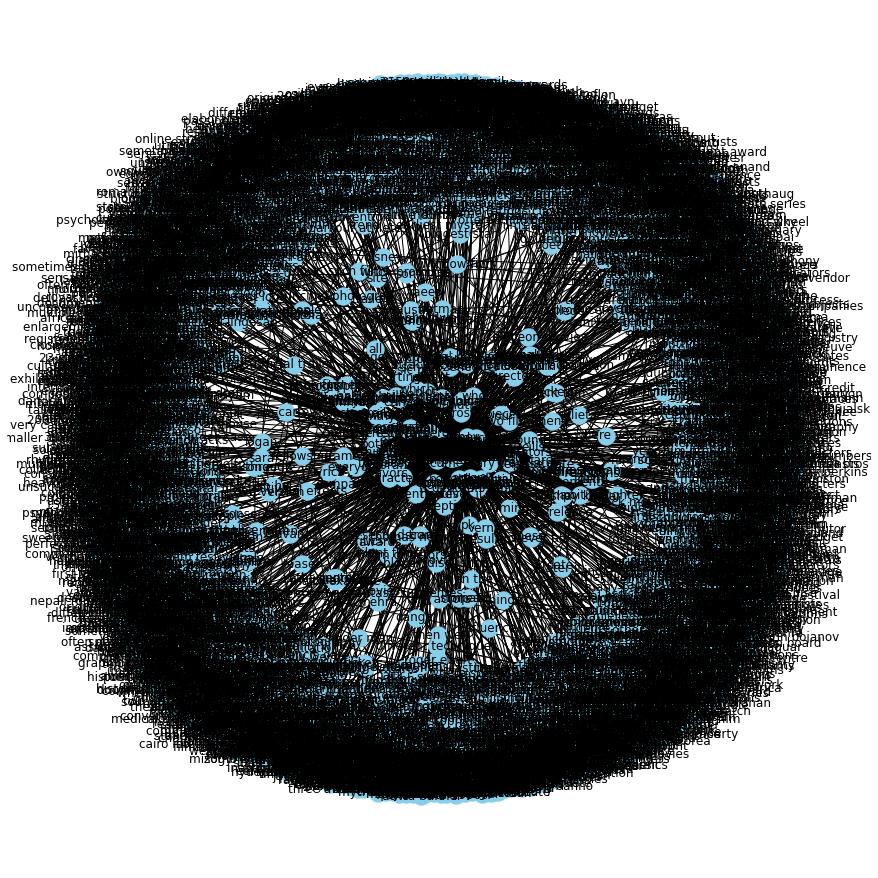

In [86]:
plt.figure(figsize=(12,12))

pos = nx.spring_layout(directed_graph)
nx.draw(directed_graph, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

In [87]:
def plot_relation_nodes(knowledge_graph_df,relation_name):
    
    rel_graph = nx.from_pandas_edgelist(knowledge_graph_df[knowledge_graph_df['relation']== relation_name],
                            "source_node", "target_node", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

    plt.figure(figsize=(12,12))
    pos = nx.spring_layout(rel_graph, k = 0.5) # k regulates the distance between nodes
    nx.draw(rel_graph, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
    plt.show()

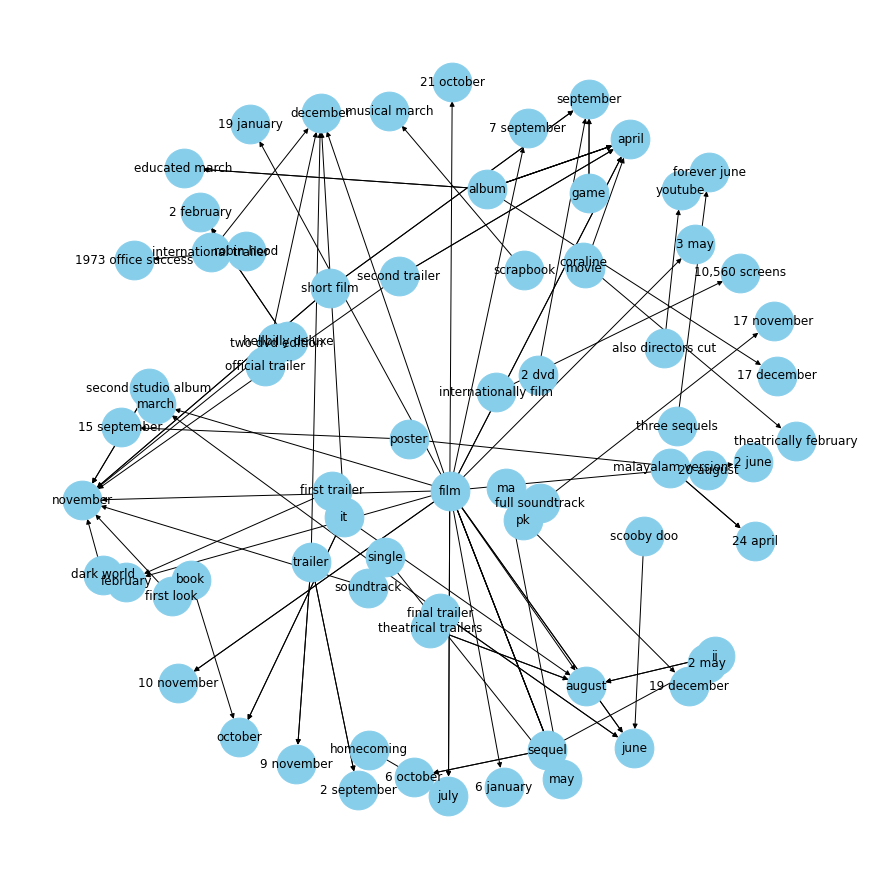

In [88]:
plot_relation_nodes(knowledge_graph_df ,'released on')

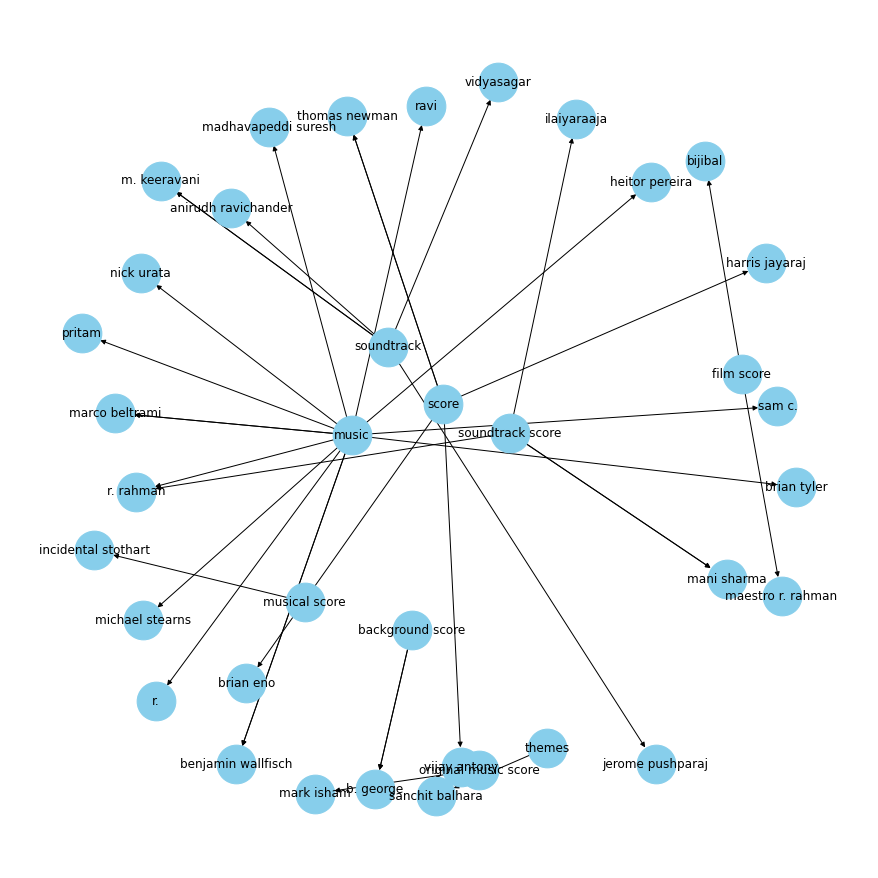

In [89]:
plot_relation_nodes(knowledge_graph_df ,'composed by')

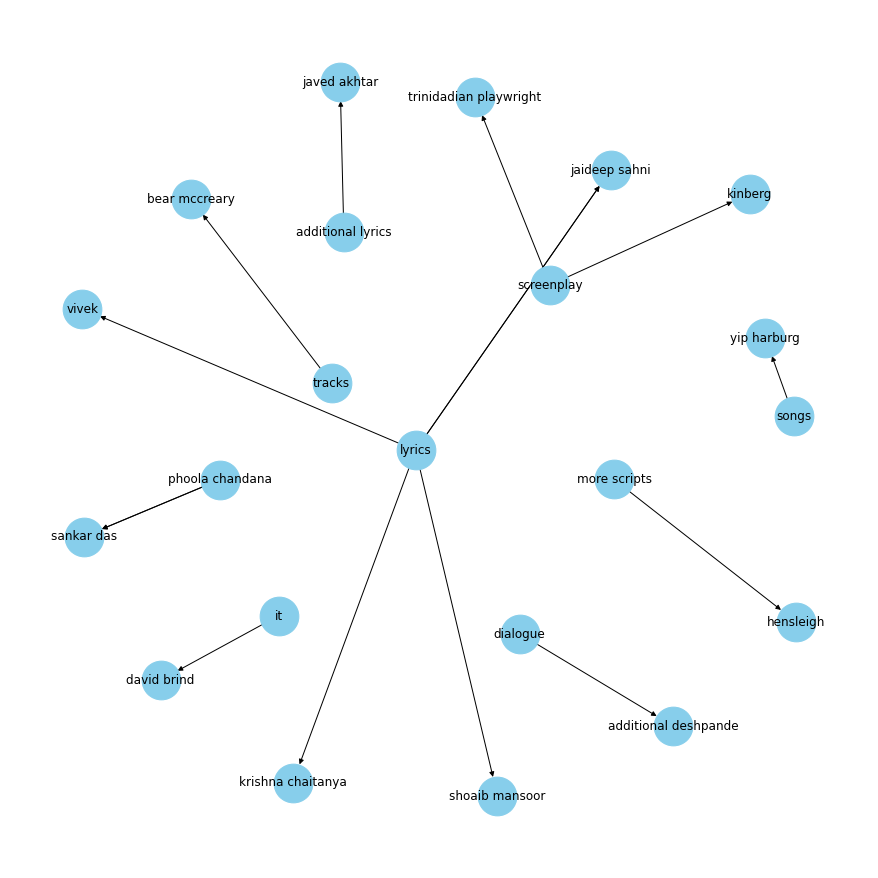

In [90]:
plot_relation_nodes(knowledge_graph_df ,'written by')